# Mid-latitude cyclone over the US west coast

This notebook visualizes an overpass of the CloudSat satellite over a mid-latitude cyclone that hit the american west coast on 3 January, 2019.


In [21]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import ccic
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from ccic.plotting import set_style
set_style()

## Define area and create surface data

In [3]:
lon_min = -140
lon_max = -100
lat_min = 30
lat_max = 60

In [4]:
from pyresample import create_area_def
area = create_area_def(
    "pacific north-west",
    {"proj": "longlat", "datum": "WGS84"},
    area_extent=[lon_min, lat_min, lon_max, lat_max],
    resolution=0.01,
    units="degrees"
)

lons, lats = area.get_lonlats()
lons = lons[0]
lats = lats[:, 0]

with xr.open_dataset("/home/simonpf/data/etopo/globe_1.nc") as data:
    elev = data.interp(latitude=lats, longitude=lons)

In [5]:
from PIL import Image
bm = np.array(Image.open("/home/simonpf/data/natural_earth/blue_marble_sep.jpg"))
bm_area = create_area_def(
    "Blue marble",
    {"proj": "longlat", "datum": "WGS84"},
    area_extent=[-180, -90, 180, 90],
    shape=bm.shape[:2]
)

In [6]:
from pyresample.kd_tree import resample_nearest
bm_r = resample_nearest(
    bm_area,
    bm,
    area,
    radius_of_influence=10e3
)

In [7]:
surface_data = elev.copy()
surface_data["texture"] = (("latitude", "longitude", "channels"), bm_r)

## Cloudsat overpass


In [8]:
from pathlib import Path
from pansat.products.satellite.cloud_sat import l2c_ice
from datetime import datetime

cs_file = Path("CloudSat/CloudSat_2C-ICE/2019003201524_67567_CS_2C-ICE_GRANULE_P1_R05_E08_F03.hdf")
if not cs_file.exists():
    start_date = datetime(2019, 1, 3, 21, 20)
    l2c_ice.download

In [9]:
from ccic.data.cloudsat import CloudSat2BCLDCLASS
from pansat.products.satellite.cloud_sat import l2b_cldclass

cld_file = Path("CloudSat/2019003201524_67567_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf")
if not cld_file.exists():
    files = sorted(CloudSat2BCLDCLASS.get_available_files(np.datetime64("2019-01-03T00:00:00")))
    CloudSat2BCLDCLASS.download(files[-3], f"CloudSat/{files[-3]}")

In [10]:
from pansat.products.satellite.cloud_sat import l2c_ice

data_cs = l2c_ice.open(cs_file)
lats_cs = data_cs.latitude.data
lons_cs = data_cs.longitude.data
inds = (lats_cs >= lat_min) * (lats_cs <= lat_max) * (lons_cs >= lon_min) * (lons_cs <= lon_max)
i_start, i_end = np.where(inds)[0][[0, -1]]
data_cs = data_cs[{"rays": slice(i_start, i_end)}]

In [11]:
data_cld = l2b_cldclass.open(cld_file)[{"rays": slice(i_start, i_end)}]

## Input observations

In [12]:
from ccic.data.cpcir import CPCIR

available_files = sorted(CPCIR.get_available_files(np.datetime64("2019-01-03T00:00:00")))
fname = available_files[-3]
CPCIR.download(fname, "/home/simonpf/data_3/ccic/results/gerard/input.nc")

In [13]:
input_data = xr.load_dataset("/home/simonpf/data_3/ccic/results/gerard/input.nc")
lon_mask = (input_data.lon.data >= lon_min) * (input_data.lon.data <= lon_max)
lat_mask = (input_data.lat.data >= lat_min) * (input_data.lat.data <= lat_max)
input_data = input_data[{"lon": lon_mask, "lat": lat_mask}]

## CCIC Data

In [14]:
from pathlib import Path
files = sorted(list(Path("/home/simonpf/copper/ccic/results/mid_latitude_cyclone/").glob("ccic*.nc")))
results = xr.open_mfdataset(files)u

/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/indexing.py:1378: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/simonpf/miniconda3/envs/ccic/lib/python3.10/site-packages/xarray/core/indexing.py:1378: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexe

In [23]:
overpass_time = np.datetime64("2019-01-03T21:15:00")
scan_start = 400
scan_end = -200

cc_i = results.cloud_type.interp(time=overpass_time, method="nearest")
results_overpass = results.interp(time=overpass_time).compute()
results_transsect = results.interp(
    time=overpass_time,
    latitude=data_cs.latitude[scan_start:scan_end],
    longitude=data_cs.longitude[scan_start:scan_end]
)
ct_i = results.cloud_type.interp(
    time=overpass_time,
    latitude=data_cs.latitude[scan_start:scan_end],
    longitude=data_cs.longitude[scan_start:scan_end],
    method="nearest"
).compute()
ct_map = results.cloud_type.interp(time=overpass_time).compute()

## Overpass

In [17]:
def great_circle_distance(lats_1, lons_1, lats_2, lons_2):
    """
    Approximate distance between locations on earth.

    Uses haversine formulat with an earth radius of 6 371 km.

    Args:
        lats_1: Latitude coordinates of starting points.
        lons_1: Longitude coordinates of starting points.
        lats_2: Latitude coordinates of target points.
        lons_2: Longitude coordinates of target points.

    Return:
        The distance between the points described by the input
        arrays in m.
    """
    lats_1 = np.deg2rad(lats_1)
    lons_1 = np.deg2rad(lons_1)
    lats_2 = np.deg2rad(lats_2)
    lons_2 = np.deg2rad(lons_2)

    d_lons = lons_2 - lons_1
    d_lats = lats_2 - lats_1

    a = np.sin(d_lats / 2.0) ** 2 + np.cos(lats_1) * np.cos(lats_2) * np.sin(
        d_lons / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    R = 6371e3
    return R * c

In [18]:
dist = []
lons = data_cs.longitude.data[scan_start:scan_end]
lats = data_cs.latitude.data[scan_start:scan_end]
lon_0 = lons[0]
lat_0 = lats[0]
for lon, lat in zip(lons, lats):
    dist.append(great_circle_distance(lat_0, lon_0, lat, lon))
dist = np.array(dist)

In [19]:
from ccic.processing import determine_column_cloud_class
cloud_counts = np.zeros(ct_map.data.shape[:-1] + (9,))
for i in range(9):
    cloud_counts[..., i] += (ct_map.data == i).sum(-1)
cloud_type_map = np.argmax(cloud_counts[..., 1:], axis=-1) + 1
cloud_free = np.all(cloud_counts[..., 1:] == 0, axis=-1)
cloud_type_map[cloud_free] = 0

NameError: name 'add_ticks' is not defined

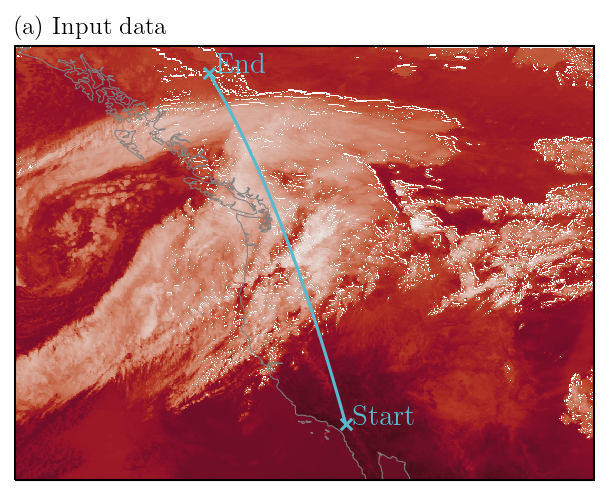

In [20]:
from ccic.data.cpcir import CPCIR_GRID
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from ccic.plotting import scale_bar, get_cloud_type_cmap

cloud_class_cmap = get_cloud_type_cmap()

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(6, 5, width_ratios=[0.075, 1.0, 0.075, 2.0, 0.075], hspace=0.3, wspace=0.15)
crs = CPCIR_GRID.to_cartopy_crs()


ax = fig.add_subplot(gs[:3, 1:2], projection=crs)
lons = input_data.lon
lats = input_data.lat
m = ax.pcolormesh(lons, lats, input_data.Tb[0].data, cmap="cmo.amp", rasterized=True)
ax.set_xlim(-140, -100)
ax.set_ylim(30, 60)
ax.set_title("(a) Input data", loc="left")
ax.coastlines(color="grey")
ax.plot(data_cs.longitude.data[scan_start:scan_end], data_cs.latitude.data[scan_start:scan_end], c="C6")
ax.text(data_cs.longitude.data[scan_start] + 0.5, data_cs.latitude.data[scan_start], s="Start", fontsize=14, color="C6")
ax.text(data_cs.longitude.data[scan_end] + 0.5, data_cs.latitude.data[scan_end], s="End", fontsize=14, color="C6")
ax.scatter(
    data_cs.longitude.data[[scan_start, scan_end]],
    data_cs.latitude.data[[scan_start, scan_end]],
    marker="x",
    s=30,
    color="C6"
)
add_ticks(ax, lats=np.linspace(30, 60, 4), lons=np.linspace(-140, -100, 5), bottom=False)

ax = fig.add_subplot(gs[:3, 0])
plt.colorbar(m, cax=ax, label="T$_b$ [K]", extend="both")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_label_position("left")

#
# IWP map
#

ax = fig.add_subplot(gs[3:, 1:2], projection=crs)
lons = results_overpass.longitude.data
lats = results_overpass.latitude.data
iwp = results_overpass.tiwp.data
norm = LogNorm(1e-3, 1e1)
m = ax.pcolormesh(lons, lats, iwp, norm=norm, rasterized=True)
levels = np.arange(9)
ax.contour(lons, lats, cloud_type_map, cmap=cloud_class_cmap, vmin=-1, vmax=8, levels=np.arange(9))
ax.set_xlim(-140, -100)
ax.set_ylim(30, 60)
ax.set_title("(b) CCIC TIWP", loc="left")
ax.coastlines(color="grey")
scale_bar(ax, 1000e3)
add_ticks(ax, lats=np.linspace(30, 60, 4), lons=np.linspace(-140, -100, 5))

ax = fig.add_subplot(gs[3:, 0])
cb = plt.colorbar(m, cax=ax, label="TIWP [kg m$^{-2}$]", extend="both")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_label_position("left")

#
#  Retrieved IWP
#

ax = fig.add_subplot(gs[0, 3])
lons_cs = data_cs.longitude.data[scan_start:scan_end]
lats_cs = data_cs.latitude.data[scan_start:scan_end]
iwp = data_cs.iwp.data[scan_start:scan_end] / 1e3
iwp_ret = results_transsect.tiwp.data
ax.plot(dist, iwp, label="2CICE")
ax.plot(dist, iwp_ret, label="Retrieved")
ax.legend()
ax.set_ylim(1e-3, 1e1)
ax.set_yscale("log")
ax.set_ylabel("TIWP [kg m$^{-2}$]")
ax.set_xticklabels([])
ax.set_title("(c) Ice water path", loc="left")

#
# 2CICE IWC
#

ax = fig.add_subplot(gs[1, 3])
norm = LogNorm(1e-3, 1e1)

lons_cs = data_cs.longitude.data[scan_start:scan_end]
lats_cs = data_cs.latitude.data[scan_start:scan_end]
height = data_cs.height.data[scan_start:scan_end] / 1e3
height = height - data_cs.surface_elevation.data[scan_start:scan_end, None] / 1e3
x = np.tile(dist[..., None], (1, height.shape[1]))
iwc = np.maximum(data_cs.iwc.data[scan_start:scan_end], 1e-4)
ax.pcolormesh(x, height, iwc, norm=norm, rasterized=True)
ax.set_ylim(0, 15)
ax.set_ylabel("Altitude [km]")
ax.set_title("(d) Total ice water content (2CICE)", loc="left")
ax.set_xticklabels([])
    
    
#
# Retrieved IWC
#

ax = fig.add_subplot(gs[2, 3])
lons_cs = data_cs.longitude.data[scan_start:scan_end]
lats_cs = data_cs.latitude.data[scan_start:scan_end]
height = results_transsect.altitude.data / 1e3
iwc = results_transsect.tiwc.data
m = ax.pcolormesh(dist, height, iwc.T, norm=norm, rasterized=True)
ax.set_ylim(0, 15)
ax.set_ylabel("Altitude [km]")
ax.set_xticklabels([])
ax.set_title("(e) Total ice water content (CCIC)", loc="left")

ax = fig.add_subplot(gs[1:3, -1])
plt.colorbar(m, cax=ax, label="TIWC [kg m$^{-3}$]", extend="both")

#
# Cloud probability
#

ax = fig.add_subplot(gs[3, 3])
lons_cs = data_cs.longitude.data[scan_start:scan_end]
lats_cs = data_cs.latitude.data[scan_start:scan_end]
height = results_transsect.altitude.data / 1e3
cp = results_transsect.cloud_prob_3d.data
m = ax.pcolormesh(dist, height, cp.T, rasterized=True)
ax.set_ylim(0, 15)
ax.set_ylabel("Altitude [km]")
ax.set_xticklabels([])
ax.set_title("(f) 3D cloud mask (retrieved)", loc="left")

ax = fig.add_subplot(gs[3, -1])
plt.colorbar(m, cax=ax, label="Cloud prob.")

#
# Cloud classification
#

cmap = get_cmap("Pastel1", 9)

ax = fig.add_subplot(gs[4, 3])
lons_cs = data_cs.longitude.data[scan_start:scan_end]
lats_cs = data_cs.latitude.data[scan_start:scan_end]
height = data_cs.height.data[scan_start:scan_end] / 1e3
height = height - data_cs.surface_elevation.data[scan_start:scan_end, None] / 1e3
x = np.tile(dist[..., None], (1, height.shape[1]))
cls = data_cld.cloud_class.data[scan_start:scan_end]
ax.pcolormesh(x, height, cls, cmap=cloud_class_cmap, vmin=0, vmax=9, rasterized=True)
ax.set_title("(g) Cloud mask", loc="left")
ax.set_xticklabels([])
ax.set_ylim(0, 15)
ax.set_ylabel("Altitude [km]")

ax = fig.add_subplot(gs[5, 3])
lons_cs = data_cs.longitude.data[scan_start:scan_end]
lats_cs = data_cs.latitude.data[scan_start:scan_end]
height = results_transsect.altitude / 1e3
cls = ct_i
m = ax.pcolormesh(dist / 1e3, height, cls.T, cmap=cloud_class_cmap, vmin=0, vmax=9, rasterized=True)
ax.set_title("(h) Cloud mask (retrieved)", loc="left")

ticks = np.concatenate([np.arange(0, dist[-1], 1e6), [dist[-1]]]) / 1e3
ax.set_xticks(ticks)
labels = ax.xaxis.get_ticklabels()
labels[0].set_text("Start")
labels[-1].set_text("End")
ax.xaxis.set_ticklabels(labels)
ax.set_xlabel("Along track distance [km]")

ax.set_ylim(0, 15)
ax.set_ylabel("Altitude [km]")

ax = fig.add_subplot(gs[4:, -1])
cb = plt.colorbar(m, cax=ax, label="Cloud class")
cb.set_ticks(np.arange(9) + 0.5)
cb.set_ticklabels(CLOUD_CLASSES)

fig.savefig("case_study_2019_01_03.pdf", dpi=200, bbox_inches="tight")

In [28]:
c_conv = cloud_class_cmap(0.8)
c_cloud = cloud_class_cmap(0.4)

In [54]:
from ccic.processing import determine_column_cloud_class

def plot_cloudsat_classes(ax, cloudsat_data):
    """
    Plot CloudSat column classes along swath.
    
    Args:
        ax: A matplotlib axes object to which to plot the classes.
        cloudsat_data: A netcdf dataset containing the CloudSat data along the overpass.
        
    Return:
        A list of handles of the drawn lines.
    """
    
    classes = determine_column_cloud_class(cloudsat_data.cloud_class.data[scan_start:scan_end])
    ax.plot(
        data_cs.longitude.data[scan_start:scan_end],
        data_cs.latitude.data[scan_start:scan_end],
        c="w",
        lw=1.2
    )
    breaks = np.where(np.diff(classes))[0]
    start = 0
    handles = {}
    for end in breaks:
        ax.plot()
        val = classes[end]
        if val == 0:
            start = end
            continue
            
        if val == 1:
            color = colors[1]
            label = "Cloud"
        else:
            color = colors[0]
            label = "Convective core"
        handles[int(val)] = ax.plot(
            data_cs.longitude.data[scan_start:scan_end][start:end],
            data_cs.latitude.data[scan_start:scan_end][start:end],
            c=color,
            label=label
        )[0]
        start = end
    #ax.text(data_cs.longitude.data[scan_start], data_cs.latitude.data[scan_start], s="Start", color="w", fontsize=12)
    ax.scatter([data_cs.longitude.data[scan_start]], [data_cs.latitude.data[scan_start]], marker="x", s=30, c="w")
    #ax.text(data_cs.longitude.data[scan_end], data_cs.latitude.data[scan_end], s="End", fontsize=12, color="w")
    ax.scatter([data_cs.longitude.data[scan_end]], [data_cs.latitude.data[scan_end]], marker="x", s=30, c="w")
    return list(handles.values())


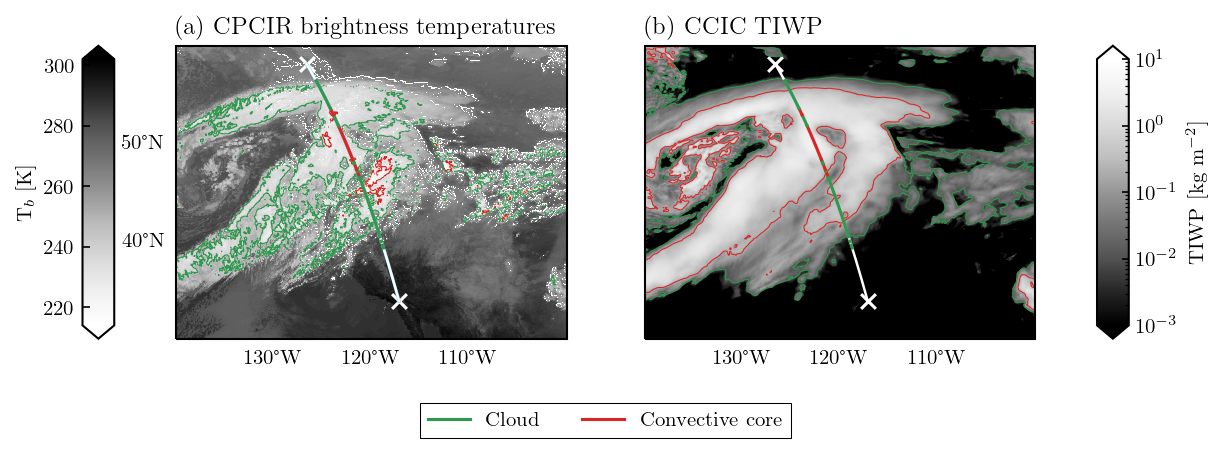

In [77]:
from ccic.plotting import add_ticks

gs = GridSpec(2, 4, width_ratios=[0.075, 1.0, 1.0, 0.075], height_ratios=[1.0, 0.2], hspace=0.3, wspace=0.2)
fig = plt.figure(figsize=(9, 3.5))

colors = [c_conv, c_cloud]
ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = input_data.lon
lats = input_data.lat
m_tbs = ax.pcolormesh(lons, lats, input_data.Tb[0].data, cmap="Greys", rasterized=True)
levels = [225, 241]
ax.contour(lons, lats, input_data.Tb[0], levels=levels, colors=colors, linewidths=0.5)
ax.set_xlim(-140, -100)
ax.set_ylim(30, 60)
ax.plot(data_cs.longitude.data[scan_start:scan_end], data_cs.latitude.data[scan_start:scan_end], c="C6")
add_ticks(ax, lats=np.linspace(30, 60, 4), lons=np.linspace(-140, -100, 5))
ax.set_title("(a) CPCIR brightness temperatures", loc="left")

plot_cloudsat_classes(ax, data_cld)
ax = fig.add_subplot(gs[0, 2], projection=crs)
lons = results_overpass.longitude.data
lats = results_overpass.latitude.data
tiwp = results_overpass.tiwp.data
norm = LogNorm(1e-3, 1e1)
m_tiwp = ax.pcolormesh(lons, lats, tiwp, norm=norm, rasterized=True, cmap="Greys_r")
ax.set_xlim(-140, -100)
ax.set_ylim(30, 60)
levels = [0.01, 0.2]
ax.contour(lons, lats, tiwp, levels=levels, colors=colors[::-1], linewidths=0.5)
add_ticks(ax, lats=np.linspace(30, 60, 4), lons=np.linspace(-140, -100, 5), left=False)
ax.set_title("(b) CCIC TIWP", loc="left")

handles = plot_cloudsat_classes(ax, data_cld)


ax = fig.add_subplot(gs[0, 0])
plt.colorbar(m_tbs, cax=ax, label="T$_b$ [K]", extend="both")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_label_position("left")

ax = fig.add_subplot(gs[0, -1])
plt.colorbar(m_tiwp, cax=ax, label="TIWP [kg m$^{-2}$]", extend="both")
#ax.plot(data_cs.longitude.data[scan_start:scan_end], data_cs.latitude.data[scan_start:scan_end], c="C6")

ax = fig.add_subplot(gs[-1, :])
ax.set_axis_off()
ax.legend(handles=handles, ncol=2, loc="center")

fig.savefig("detection_thresholds.pdf", bbox_inches="tight")

## 3D Scene

In [15]:
import pyvista as pv

In [16]:
import cmocean
from scipy.signal import convolve
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import BoundaryNorm
import pyvista as pv

LEVELS = np.logspace(-2, 0, 11)
#LEVELS = np.linspace(0, 1, 11)[1:]
CMAP = get_cmap("cmo.dense").copy()
CMAP.set_under("#FFFFFF88")
NORM = BoundaryNorm(LEVELS, CMAP.N)
MAPPABLE = ScalarMappable(norm=NORM, cmap=CMAP)
lt = pv.LookupTable(
    "cmo.dense",
    n_values=len(LEVELS),
    scalar_range=(1e-2, 1e0),
    log_scale=True
)


def tiwc_contours(data, surface_data):
    """
    Calculate TIWC iso-surfaces.
    
    Args:
        data: An xarray.Dataset containing the retrieval results.
        surface_data: An xarray.Dataset containing the surface elevation data.
        
    Return:
        A tuple ``(contours, colors)`` containing the pyvista surfaces representing
        the TIWC contours and the corresponding colors.
    """
    x = data.longitude.data.astype(np.float32)
    y = data.latitude.data.astype(np.float32)
    
    elev = surface_data.elevation.interp(
        latitude=data.latitude,
        longitude=data.longitude,
        method="nearest",
        kwargs={"fill_value": "extrapolate"}
    ).data
    
    k = np.ones((8, 8))
    elev_sum = convolve(elev, k, "same")
    elev_cts = convolve(np.ones_like(elev), k, "same")
    elev = elev_sum / elev_cts
    
    z = elev[:, :, None] + data.altitude.data[None, None, :]
    
    x, y, _ = np.meshgrid(x, y, data.altitude.data / 5e3)
    grid = pv.StructuredGrid(x, y, z / 5e3)
    grid["TIWC [g / m^3]"] = data.tiwc.data.flatten(order="f")
    
    cts = grid.contour(LEVELS)
    colors = MAPPABLE.to_rgba(LEVELS)
    colors[:, -1] = np.linspace(0.1, 1.0, colors.shape[0])
    return cts, colors

/tmp/ipykernel_2482827/1942057236.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CMAP = get_cmap("cmo.dense").copy()


In [17]:
import cmocean

def make_texture(iwc):
    img = MAPPABLE.to_rgba(iwc)
    return img

def radar_curtain(data, time=1.0):
    lats = data.latitude.data
    lons = data.longitude.data
    n_bins = data.bins.size
    
    lon_coords = []
    lat_coords = []
    height = []
    iwc = []
    t_coords_0 = []
    t_coords_1 = []
    
    elev = np.maximum(data_cs.surface_elevation.data, 0.0)
    
    n_rays = lats.size
    rays_t = int(time * n_rays)
    
    for i in range(rays_t):
        i_end = np.where(data_cs.height.data[i] > elev[i])[0][-1]
        i_start = i_end - 60
        lon_coords.append(lons[i] * np.ones(60))
        lat_coords.append(lats[i] * np.ones(60))
        height.append(data.height.data[i][i_start:i_end].copy())
        height[-1][0] = 20e3
        iwc.append(data.iwc.data[i][i_start:i_end])
        
        t_coords_0.append(np.ones(60) * i / rays_t)
        t_coords_1.append(np.linspace(1, 0, 60))
    
    lon_coords = np.concatenate(lon_coords)
    lat_coords = np.concatenate(lat_coords)
    height = np.concatenate(height)
    print(height.max())
    coords = np.stack([lon_coords, lat_coords, height / 5e3], -1)
    grid = pv.StructuredGrid()
    grid.points = coords
    grid.dimensions = 60, rays_t, 1
    iwc = np.stack(iwc, -1)
    img = (255 * make_texture(iwc)).astype("uint8")
    txt = pv.numpy_to_texture(img)
    
    t_coords = np.stack([
        np.concatenate(t_coords_0),
        np.concatenate(t_coords_1),
    ], axis=-1)
    grid.texture_map_to_plane(inplace=True)
    grid["Texture Coordinates"] = t_coords
    
    return grid, txt
    
def radar_to_poly(data):
    lats = data.latitude.data
    lons = data.longitude.data
    
    n_rays = lats.size
    points = []
    faces = []
    
    
    for i, ind in enumerate(range(0, n_rays, 10)):
        p = np.zeros((2, 3))
        p[:, 0] = lons[ind]
        p[:, 1] = lats[ind]
        p[0, 2] = data.height.data[ind, 0] / 5e3
        p[1, 2] = data.height.data[ind, -1] / 5e3
        points.append(p)
        
        if i > 0:
            f_ind = 2 * i
            faces.append([4, f_ind - 2, f_ind, f_ind + 1, f_ind - 1])
            
    points = np.concatenate(points, 0)
    faces = np.concatenate(faces)
    
    pd = pv.PolyData(points, faces=faces)
    return pd

In [18]:
def surface(data):
    lats = data.latitude.data
    lons = data.longitude.data
    z = data.elevation.data / 5e3
    x, y = np.meshgrid(lons, lats)
    grid = pv.StructuredGrid(x, y, z)
    grid.texture_map_to_plane(
        inplace=True,
        origin=[lon_min, lat_min, 0],
        point_u=[lon_max, lat_min, 0],
        point_v=[lon_min, lat_max, 0]
    )
    txt = pv.numpy_to_texture(data.texture.data)
    return grid, txt


In [19]:
def setup_camera(scene):
    scene.camera_position = 'yz'
    scene.camera.elevation = 15
    scene.camera.zoom(1.5)
    scene.camera.zoom(1.5)
    scene.camera.zoom(1.2)
    scene.azimuth = 0
    

In [24]:
from pansat.time import to_datetime64
iwc, colors = tiwc_contours(results.interp(time=to_datetime64(overpass_time)).compute(), surface_data)

In [25]:
rc, txt_rc = radar_curtain(data_cs)

20000


In [26]:
rp = radar_to_poly(data_cs)

In [27]:
sfc, txt = surface(surface_data)

In [ ]:
iwc = iwc.compute_implicit_distance(rp, inplace=False)
#iwc_ocean = iwc.threshold(0.0, scalars="implicit_distance", invert=False)
#iwc_land = iwc.threshold(0.0, scalars="implicit_distance", invert=True)

In [28]:
iwc.compute_implicit_distance?

## Evolution

In [25]:
pv.set_jupyter_backend("static")

In [36]:
scene = pv.Plotter(multi_samples=64, window_size=(1600, 800), line_smoothing=True, polygon_smoothing=True, point_smoothing=True)
scene.enable_depth_peeling()
scene.set_background("white")
scene.add_mesh(sfc, texture=txt);
#scene.add_mesh(iwc_ocean, scalars="iwc", cmap=[to_hex(c) for c in colors], clim=[0, 1], ambient=0.2, smooth_shading=True, opacity=0.3, n_colors=len(colors))
#scene.add_mesh(iwc_land, scalars="iwc", cmap=[to_hex(c) for c in colors], clim=[0, 1], ambient=0.2, smooth_shading=True, opacity=0.3, n_colors=len(colors));
#scene.add_mesh(rc, texture=txt_rc);
scene.add_mesh(iwc, opacity=0.3, ambient=0.1, cmap="cmo.dense", clim=[0, 1]);

In [37]:
setup_camera(scene)

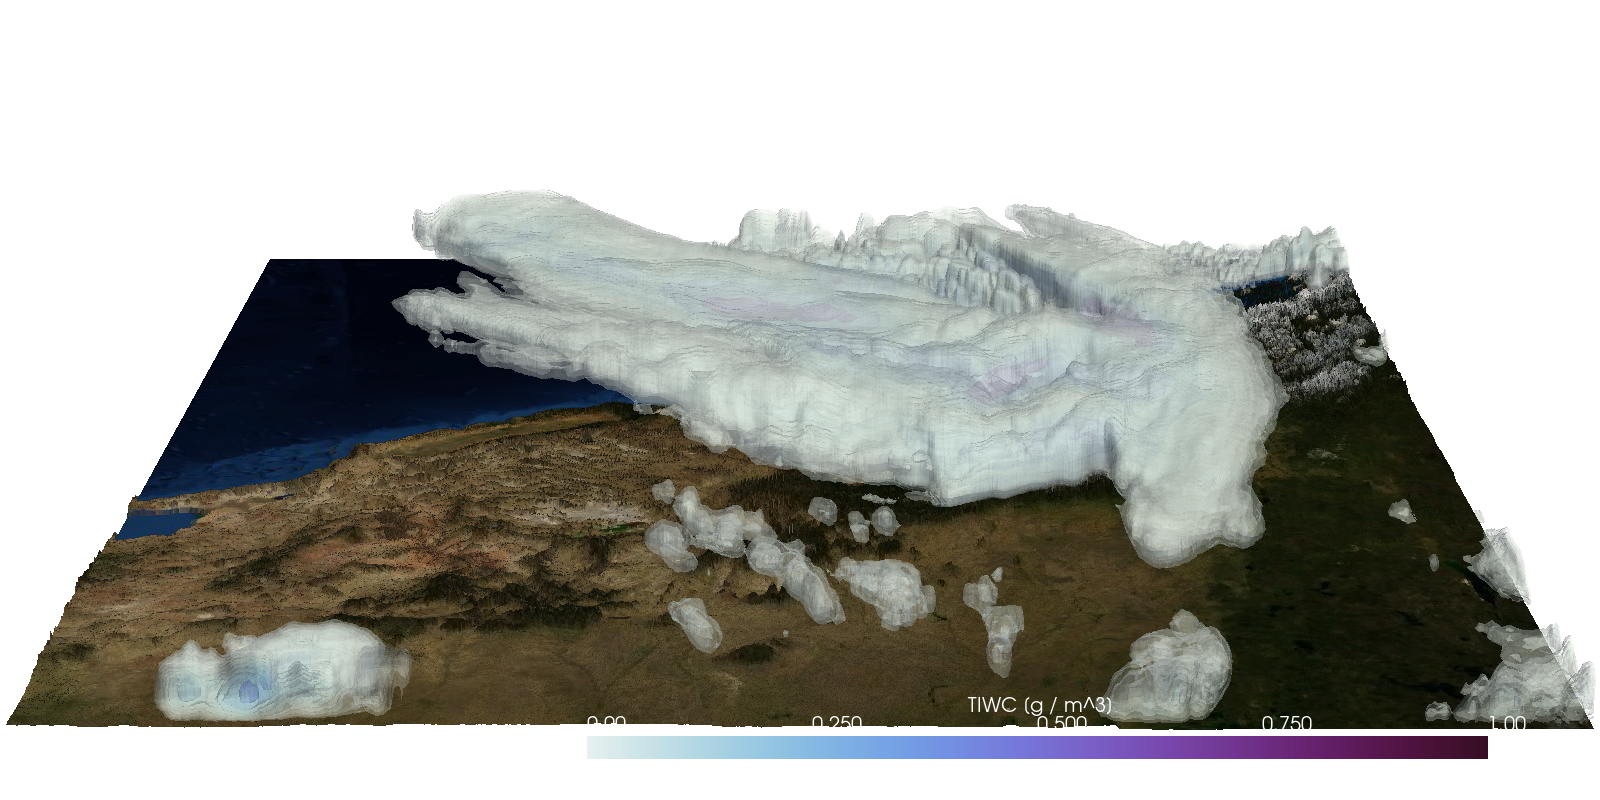

In [38]:
scene.show()

In [ ]:
results = results.compute()

In [ ]:
scene.open_movie("mlc_evolution_log.mp4")

In [ ]:
from matplotlib.colors import to_hex
start_time = np.datetime64("2019-01-03T00:00:00")
end_time = to_datetime64(overpass_time)
actor = None
n_steps = 540
for i in range(n_steps + 1):
    time = start_time + (end_time - start_time) / n_steps * i# time in np.arange(start_time, end_time, np.timedelta64(600, "s"))[:10]:
    print(time)
    scene.camera.azimuth = -180 + 180 / 540 * i
    if actor is not None:
        scene.remove_actor(actor)
    iwc_t, colors_t = iwc_contours(results.interp(time=time), surface_data)
    actor = scene.add_mesh(iwc_t, scalars="TIWC [g / m^3]", cmap=lt, ambient=0.2, smooth_shading=True, opacity=0.3);
    scene.write_frame()

2019-01-03T00:00:00.000000000
2019-01-03T00:02:21.942370370
2019-01-03T00:04:43.884740740
2019-01-03T00:07:05.827111110
2019-01-03T00:09:27.769481480
2019-01-03T00:11:49.711851850
2019-01-03T00:14:11.654222220
2019-01-03T00:16:33.596592590
2019-01-03T00:18:55.538962960
2019-01-03T00:21:17.481333330
2019-01-03T00:23:39.423703700
2019-01-03T00:26:01.366074070
2019-01-03T00:28:23.308444440
2019-01-03T00:30:45.250814810
2019-01-03T00:33:07.193185180
2019-01-03T00:35:29.135555550
2019-01-03T00:37:51.077925920
2019-01-03T00:40:13.020296290
2019-01-03T00:42:34.962666660
2019-01-03T00:44:56.905037030
2019-01-03T00:47:18.847407400
2019-01-03T00:49:40.789777770
2019-01-03T00:52:02.732148140
2019-01-03T00:54:24.674518510
2019-01-03T00:56:46.616888880
2019-01-03T00:59:08.559259250
2019-01-03T01:01:30.501629620
2019-01-03T01:03:52.443999990
2019-01-03T01:06:14.386370360
2019-01-03T01:08:36.328740730
2019-01-03T01:10:58.271111100
2019-01-03T01:13:20.213481470
2019-01-03T01:15:42.155851840
2019-01-03

In [ ]:
scene.close()

In [168]:
pv.StructuredGrid.contour?

### Cloudsat curtain

In [201]:
from matplotlib.colors import to_hex
scene = pv.Plotter(multi_samples=32, window_size=(1600, 800), line_smoothing=True, polygon_smoothing=True, point_smoothing=True)
scene.set_background("white")

scene.add_mesh(sfc, texture=txt)
scene.add_mesh(iwc_ocean, scalars="IWC [g / m^3]", cmap=lt, ambient=0.2, smooth_shading=True, opacity=0.3);
scene.add_mesh(iwc_land, scalars="IWC [g / m^3]", cmap=lt, ambient=0.2, smooth_shading=True, opacity=0.3);

In [202]:
setup_camera(scene)

In [203]:
scene.open_movie("mlc_curtain_log.mp4")

In [204]:
n_steps = 120
actor = None
for i in range(n_steps):
    print(i)
    rc, txt_rc = radar_curtain(data_cs, time= (i + 1) / n_steps)
    if actor is not None:
        scene.remove_actor(actor)
    actor = scene.add_mesh(rc, texture=txt_rc)
    scene.write_frame()

0
20000
1
20000
2
20000
3
20000
4
20000
5
20000
6
20000
7
20000
8
20000
9
20000
10
20000
11
20000
12
20000
13
20000
14
20000
15
20000
16
20000
17
20000
18
20000
19
20000
20
20000
21
20000
22
20000
23
20000
24
20000
25
20000
26
20000
27
20000
28
20000
29
20000
30
20000
31
20000
32
20000
33
20000
34
20000
35
20000
36
20000
37
20000
38
20000
39
20000
40
20000
41
20000
42
20000
43
20000
44
20000
45
20000
46
20000
47
20000
48
20000
49
20000
50
20000
51
20000
52
20000
53
20000
54
20000
55
20000
56
20000
57
20000
58
20000
59
20000
60
20000
61
20000
62
20000
63
20000
64
20000
65
20000
66
20000
67
20000
68
20000
69
20000
70
20000
71
20000
72
20000
73
20000
74
20000
75
20000
76
20000
77
20000
78
20000
79
20000
80
20000
81
20000
82
20000
83
20000
84
20000
85
20000
86
20000
87
20000
88
20000
89
20000
90
20000
91
20000
92
20000
93
20000
94
20000
95
20000
96
20000
97
20000
98
20000
99
20000
100
20000
101
20000
102
20000
103
20000
104
20000
105
20000
106
20000
107
20000
108
20000
109
20000
110
20000


In [206]:
scene.close()

## Remove half 

In [207]:
from matplotlib.colors import to_hex
scene = pv.Plotter(multi_samples=32, window_size=(1600, 800), line_smoothing=True, polygon_smoothing=True, point_smoothing=True)
scene.set_background("white")
scene.add_mesh(sfc, texture=txt)
scene.add_mesh(rc, texture=txt_rc)
scene.add_mesh(iwc_ocean, scalars="IWC [g / m^3]", cmap=lt, ambient=0.2, smooth_shading=True, opacity=0.3);
a_land = scene.add_mesh(iwc_land, scalars="IWC [g / m^3]", cmap=lt, ambient=0.2, smooth_shading=True, opacity=0.3);

In [208]:
setup_camera(scene)

In [209]:
scene.open_movie("mlc_opacity.mp4")
n_steps = 40
for i in range(n_steps):
    a_land.prop.opacity = 1.0 - i / n_steps
    scene.write_frame()
scene.close()

## Rotation with half removed

In [210]:
from matplotlib.colors import to_hex
scene = pv.Plotter(multi_samples=32, window_size=(1600, 800), line_smoothing=True, polygon_smoothing=True, point_smoothing=True)
scene.set_background("white")
scene.add_mesh(sfc, texture=txt)
scene.add_mesh(rc, texture=txt_rc)
scene.add_mesh(iwc_ocean, scalars="IWC [g / m^3]", cmap=lt, ambient=0.2, smooth_shading=True, opacity=0.3, n_colors=len(colors));
#a_land = scene.add_mesh(iwc_land, scalars="iwc", cmap=[to_hex(c) for c in colors], clim=[0, 1], ambient=0.2, smooth_shading=True, opacity=0.3, n_colors=len(colors));

In [211]:
setup_camera(scene)

In [212]:
scene.open_movie("mlc_rotation_log.mp4")
n_steps = 540
for i in range(n_steps):
    print(i)
    scene.camera.azimuth = 360 / 540 * i
    scene.write_frame()
scene.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27